In [16]:
from features import map_sequences_to_features
from aux import load_files, load_test, train_validate_split, nfolds_cross_validate, tuples_to_matrices
from aux import FILES as labels_fasta 
from categorical import CategoricalClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC


from scipy import interp

import numpy as np
from matplotlib import pyplot as plt

import itertools
from itertools import cycle
np.random.seed(0)

In [3]:
def get_models_and_params():
    '''Used in grid search'''
    return [
    (CategoricalClassifier(), {
        "p_vector" : [[0.25, 0.25, 0.25, 0.25]]
    }),
    (OneVsRestClassifier(RandomForestClassifier()),{ 
        "estimator__n_estimators": [200, 300, 400, 450, 500],
        "estimator__criterion": ["gini"],
        "estimator__n_jobs": [-1]
    }),
    (AdaBoostClassifier(),{ 
        "n_estimators": [50, 100, 200, 400],
        "learning_rate": [0.1, 0.25, 1, 2],
    }),   

    ]


In [4]:
def run_test_models():
    tv_split = 0.2
    file_data = load_files()
    feature_data, keys = map_sequences_to_features(file_data)
    np.random.shuffle(feature_data)
    
    train_and_validate, test = train_validate_split(tv_split, feature_data)
    X, Y = tuples_to_matrices(train_and_validate)

    model_and_grid = get_models_and_params()
    fitted_models = []
    for model, grid in model_and_grid:
        print(model)
        clf = GridSearchCV(model, grid, cv=5)
        clf.fit(X,Y)
        fitted_models.append(clf)
    return fitted_models, train_and_validate, test, keys
models, train_val, test, keys = run_test_models()

['aromaticity', 'end_letter_A', 'end_letter_C', 'end_letter_D', 'end_letter_E', 'end_letter_F', 'end_letter_G', 'end_letter_H', 'end_letter_I', 'end_letter_J', 'end_letter_K', 'end_letter_L', 'end_letter_M', 'end_letter_N', 'end_letter_O', 'end_letter_P', 'end_letter_Q', 'end_letter_R', 'end_letter_S', 'end_letter_T', 'end_letter_U', 'end_letter_V', 'end_letter_W', 'end_letter_Y', 'end_letter_Z', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'isoelectric', 'mol_weight', 'seq_length', 'start_letter_A', 'start_letter_C', 'start_letter_D', 'start_letter_E', 'start_letter_F', 'start_letter_G', 'start_letter_H', 'start_letter_I', 'start_letter_J', 'start_letter_K', 'start_letter_L', 'start_letter_M', 'start_letter_N', 'start_letter_O', 'start_letter_P', 'start_letter_Q', 'start_letter_R', 'start_letter_S', 'start_letter_T', 'start_letter_U

In [5]:
def get_accuracies(clf, test):
    print("Average Cross Validation Score, ",clf.best_score_)
    print("Params", clf.best_params_)
    mean_cv = clf.cv_results_["mean_test_score"][0]
    std_cv = clf.cv_results_["std_test_score"][0]
    mean_train = clf.cv_results_["mean_train_score"][0]
    std_train = clf.cv_results_["std_train_score"][0]
    print("Mean CV Train Accuracy: {} ± {}".format(mean_train, std_train))
    print("Mean CV Valid Accuracy: {} ± {}".format(mean_cv, std_cv))
    
    X, Y = tuples_to_matrices(test)
    best_score = clf.best_estimator_.score(X, Y)
    Y_pred = clf.best_estimator_.predict(X)
    f1 = f1_score(Y, Y_pred, average="weighted")
    print("Holdout Test Accuracy: {}".format(best_score)) 
    print("F1 Acc: {:.3f}".format(f1))
    return clf.best_estimator_

best_classifiers = [get_accuracies(m, test) for m in models]
# [CC, RF, Ada]

Average Cross Validation Score,  0.28476551911087017
Params {'p_vector': [0.25, 0.25, 0.25, 0.25]}
Mean CV Train Accuracy: 0.2860862042707104 ± 0.006451044966225547
Mean CV Valid Accuracy: 0.28476551911087017 ± 0.009793499304989605
Holdout Test Accuracy: 0.2955531453362256
F1 Acc: 0.282
Average Cross Validation Score,  0.6797235023041475
Params {'estimator__criterion': 'gini', 'estimator__n_estimators': 400, 'estimator__n_jobs': -1}
Mean CV Train Accuracy: 1.0 ± 0.0
Mean CV Valid Accuracy: 0.6768772024939008 ± 0.009755306601137976


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Holdout Test Accuracy: 0.6822125813449024
F1 Acc: 0.681
Average Cross Validation Score,  0.6337760910815939
Params {'learning_rate': 0.25, 'n_estimators': 200}
Mean CV Train Accuracy: 0.5754271044634796 ± 0.0037771221693531235
Mean CV Valid Accuracy: 0.568717809704527 ± 0.007773810683431567
Holdout Test Accuracy: 0.6426247288503254
F1 Acc: 0.646


In [6]:
def get_metrics_from_classifier(clfs, test):
    metrics = []
    for clf in clfs:
        X, Y = tuples_to_matrices(test)
        Y_pred = clf.predict(X)
        metrics = precision_recall_fscore_support(Y, Y_pred)
        labels = ["Cyto", "Mito", "Nucl", "Secr"]
        for i, (p, r, f, s) in enumerate(zip(*metrics)):
            print("        & {} & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ \\\\".format(labels[i],p,r,f,s))
        print("\midrule")
get_metrics_from_classifier(best_classifiers, test)


        & Cyto & $0.305$ & $0.288$ & $0.296$ & $590.000$ \\
        & Mito & $0.165$ & $0.171$ & $0.168$ & $258.000$ \\
        & Nucl & $0.377$ & $0.387$ & $0.382$ & $671.000$ \\
        & Secr & $0.188$ & $0.191$ & $0.189$ & $325.000$ \\
\midrule
        & Cyto & $0.601$ & $0.564$ & $0.582$ & $590.000$ \\
        & Mito & $0.744$ & $0.620$ & $0.677$ & $258.000$ \\
        & Nucl & $0.664$ & $0.733$ & $0.697$ & $671.000$ \\
        & Secr & $0.817$ & $0.840$ & $0.829$ & $325.000$ \\
\midrule
        & Cyto & $0.510$ & $0.558$ & $0.533$ & $590.000$ \\
        & Mito & $0.711$ & $0.628$ & $0.667$ & $258.000$ \\
        & Nucl & $0.636$ & $0.639$ & $0.637$ & $671.000$ \\
        & Secr & $0.895$ & $0.815$ & $0.853$ & $325.000$ \\
\midrule


In [7]:
random_forest = best_classifiers[1]

In [8]:
print(random_forest.classes_)


[0 1 2 3]


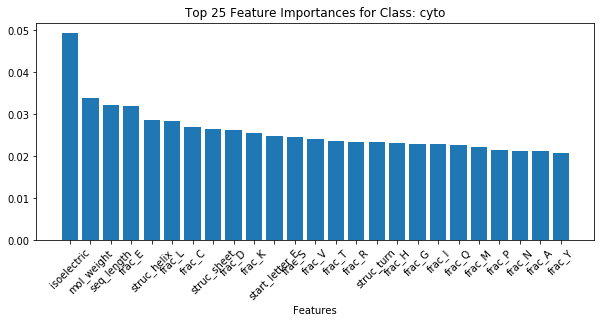

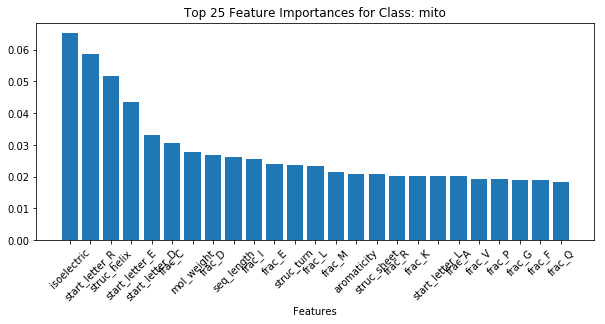

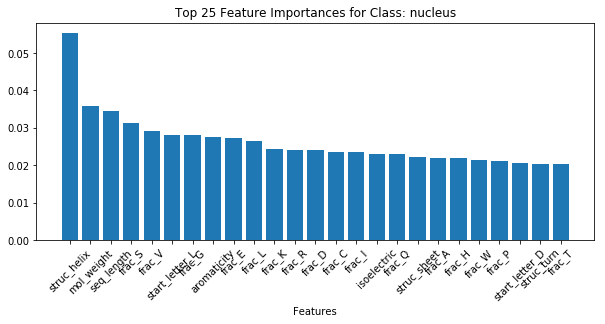

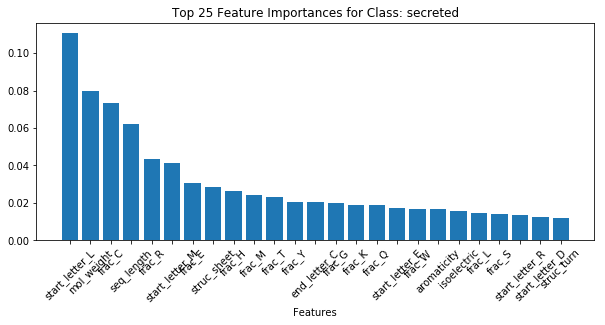

In [9]:
model = random_forest
def one_vs_many_graphs(model):
    k = keys[:]
    for i, est in enumerate(model.estimators_):
        l = labels_fasta[model.classes_[i]].replace(".fasta","")
        fi, k_s = list(zip(*sorted(list(zip(est.feature_importances_, keys)), key=lambda x:x[0], reverse=True)))
        plt.figure(figsize=(10,4))
        plt.bar(k_s[:25], fi[:25])
        plt.xticks(rotation=45)
        plt.xlabel("Features")
        plt.title("Top 25 Feature Importances for Class: {}".format(l))
        plt.show()
one_vs_many_graphs(model)


In [10]:
len(keys)

75

In [11]:
def plot_roc_auc(y_test, y_score, label_names):
    n_classes = 4
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(label_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class classifier')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.56440678 0.04237288 0.34576271 0.04745763]
 [0.18217054 0.62015504 0.12790698 0.06976744]
 [0.22056632 0.02384501 0.73323398 0.02235469]
 [0.08       0.04307692 0.03692308 0.84      ]]
Confusion matrix, without normalization
[[333  25 204  28]
 [ 47 160  33  18]
 [148  16 492  15]
 [ 26  14  12 273]]


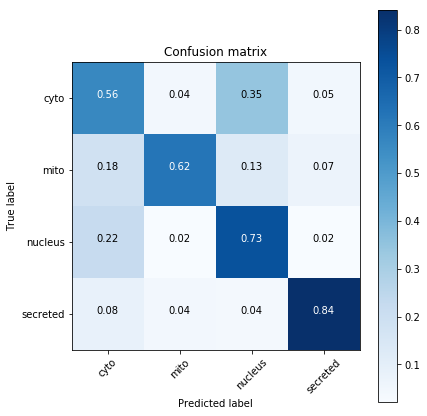

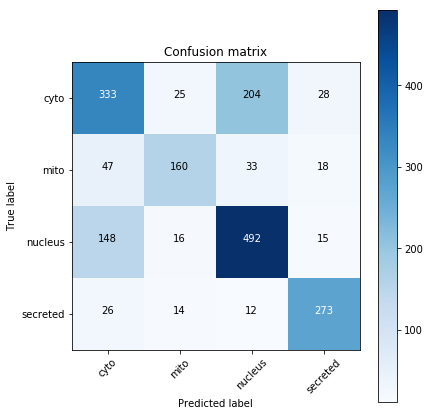

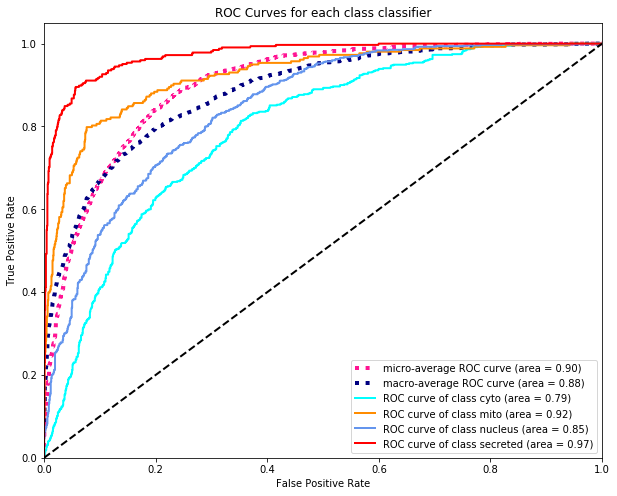

In [13]:


label_names = [l.replace(".fasta","") for l in labels_fasta]
X_val, Y_val = tuples_to_matrices(test)
Y_predict_proba = model.predict_proba(X_val)
Y_predict = model.predict(X_val)
cm = confusion_matrix(Y_val, Y_predict)

Y_val_bin = label_binarize(Y_val, classes=[0, 1, 2, 3])
Y_pred_bin = label_binarize(Y_predict, classes=[0, 1, 2, 3])

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, label_names, normalize=True)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, label_names, normalize=False)

plot_roc_auc(Y_val_bin, Y_predict_proba, label_names)

In [17]:
def predict_model(model):
    seq = load_test()
    feat, keys = map_sequences_to_features(seq)
    return feature_data, filedata, keys
    print(len(feat))
    X, _ = tuples_to_matrices(feat)
    Y_pred = model.predict(X)
    Y_proba = model.predict_proba(X)
    L=["Cyto", "Mito", "Nucleus", "Secreted"]

    even = True
    buff = []
    for guess, (seq, _), p in zip(Y_pred, seq, Y_proba):
    #     print("{} & {} & {:3f} \\\\".format(seq.id, L[guess], np.max(p)))
        string = "{} & {} & {:3f} ".format(seq.id, L[guess], np.max(p))
        buff.append(string)

    for c1, c2 in zip(buff[:10], buff[10:20]):
        print(c1 + " & " + c2 + " \\\\")
predict_model(model)


NameError: name 'map_sequences_to_features' is not defined